# Name: Nalet

- Please answer the question in the same order as in the assignment and use the same question numbers;
- Don't answer the questions in the code comments. Use the text cells in your notebook;
- Remove clutter such as unused code lines instead of turning them into comments;
- Make sure the right execution order of the notebook cells is from top to bottom. A TA should be able to reproduce your results by simply clicking "Run All" without having to guess which cells should be executed first.

# Assignment 1 ATML 2020
Download the dataset files from ILIAS and put them in the same folder as this notebook.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
!pip install -U tqdm
import torch
from tqdm.notebook import tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

images = np.load('data/imgs_train.npy')
labels = np.load('data/labels_train.npy')

test_images = np.load('data/imgs_test.npy')
test_labels = np.load('data/labels_test.npy')

print(images.shape)
print(labels.shape, np.unique(labels))
print(test_images.shape)
print(test_labels.shape, np.unique(test_labels))

Requirement already up-to-date: tqdm in /usr/local/lib/python3.6/dist-packages (4.43.0)
(5000, 64, 64, 3)
(5000,) [0 1 2 3 4 5 6 7 8 9]
(8000, 64, 64, 3)
(8000,) [0 1 2 3 4 5 6 7 8 9]


## Task 1. Prepare data for training and model selection

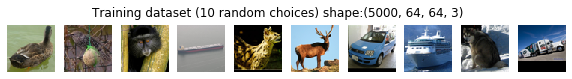

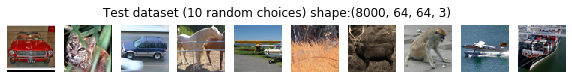

In [0]:
%matplotlib inline

img_choices = np.random.choice(5000, 10)
fig, axs = plt.subplots(1, 10, figsize=(10, 3))
for ax, selected_img in zip(axs, img_choices):
    ax.imshow(images[selected_img])
    ax.axis('off')

fig.suptitle('Training dataset (10 random choices) shape:' + str(images.shape))
fig.subplots_adjust(top=1.45)    
plt.show()

img_choices = np.random.choice(5000, 10)
fig, axs = plt.subplots(1, 10, figsize=(10, 3))
for ax, selected_img in zip(axs, img_choices):
    ax.imshow(test_images[selected_img])
    ax.axis('off')

fig.suptitle('Test dataset (10 random choices) shape:' + str(test_images.shape))
fig.subplots_adjust(top=1.45)    
plt.show()

In [0]:
import torch
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, ToTensor, Normalize, Compose, ToPILImage
class NumpyDataset(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target
        
    def __getitem__(self, index):
        # Anything could go here, e.g. image loading from file or a different structure
        # must return samples and targets/labels (x and y in our case)
        datapoint = self.data[index]
        target = self.target[index]
        return datapoint, target
    
    def __len__(self):
        return len(self.data)
        # must return number of examples

# class NumpyDataset(Dataset):
#     def __init__(self, data, target, transform=None):
#         self.data = torch.from_numpy(data)
#         self.target = torch.from_numpy(target)
#         self.transform = transform
        
#     def __getitem__(self, index):
#         x = self.data[index]
#         y = self.target[index]
        
#         if self.transform:
#             x = self.transform(x)
        
#         return x, y
    
#     def __len__(self):
#         return len(self.data)




target_size = (32, 32)
transforms = Compose([ToPILImage(), 
                      # Resize(target_size), # Resizes image
                    ToTensor(),           # Converts to Tensor, scales to [0, 1] float (from [0, 255] int)
                    Normalize(mean=(0.5, 0.5, 0.5,), std=(0.5, 0.5, 0.5)), # scales to [-1.0, 1.0]
                    ])
images_ = []
test_images_ = []

for img in tqdm(images):
  images_.append(transforms(img))

for img in tqdm(test_images):
  test_images_.append(transforms(img))

images = images_
test_images = test_images_


train_dataset = NumpyDataset(images, labels)

In [0]:
from torch.utils.data import DataLoader
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4) #num_workers = n - how many threads in background for efficient loading

In [0]:
val_dataset = NumpyDataset(test_images, test_labels)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
print(len(val_dataset), len(train_dataset))

8000 5000


In [0]:
import torch.nn as nn
class LinearModel(nn.Module):
    
    def __init__(self, input_dim):
        super(LinearModel, self).__init__()
        self.fc = nn.Linear(input_dim, 10, bias=True) # outputs 2 values - score for cat and score for dog
        
    def forward(self, input):
        out = input.view(input.size(0), -1) # convert batch_size x 3 x imH x imW to batch_size x (3*imH*imW)
        out = self.fc(out) # Applies out = input * A + b. A, b are parameters of nn.Linear that we want to learn
        return out
    
class MLPModel(nn.Module):
    
    def __init__(self, input_dim, hidden_dim):
        super(MLPModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 10)
        )
    
    def forward(self, input):
        input = input.view(input.size(0), -1)
        return self.layers(input)

In [0]:
import numpy as np

model = LinearModel(64*64*3)
model = model.to(device)

# Initialize loss function, optimizer and parameters
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

def train_epoch(model, train_dataloader, optimizer, loss_fn):
    losses = []
    correct_predictions = 0
    # Iterate mini batches over training dataset
    for images, labels in tqdm(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        # Run predictions
        output = model(images)
        # Set gradients to zero
        optimizer.zero_grad()
        # Compute loss
        loss = loss_fn(output, labels)
        # Backpropagate (compute gradients)
        loss.backward()
        # Make an optimization step (update parameters)
        optimizer.step()
        # Log metrics
        losses.append(loss.item())
        predicted_labels = output.argmax(dim=1)
        correct_predictions += (predicted_labels == labels).sum().item()
    accuracy = 100.0 * correct_predictions / len(train_dataloader.dataset)
    # Return loss values for each iteration and accuracy
    mean_loss = np.array(losses).mean()
    return mean_loss, accuracy

def evaluate(model, dataloader, loss_fn):
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            # Run predictions
            output = model(images)
            # Compute loss
            loss = loss_fn(output, labels)
            # Save metrics
            predicted_labels = output.argmax(dim=1)
            correct_predictions += (predicted_labels == labels).sum().item()
            losses.append(loss.item())
    mean_loss = np.array(losses).mean()
    accuracy = 100.0 * correct_predictions / len(dataloader.dataset)
    # Return mean loss and accuracy
    return mean_loss, accuracy

def train(model, train_dataloader, val_dataloader, optimizer, n_epochs, loss_function):
    # We will monitor loss functions as the training progresses
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(n_epochs):
        model.train()
        train_loss, train_accuracy = train_epoch(model, train_dataloader, optimizer, loss_fn)
        model.eval()
        val_loss, val_accuracy = evaluate(model, val_dataloader, loss_fn)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        print('Epoch {}/{}: train_loss: {:.4f}, train_accuracy: {:.4f}, val_loss: {:.4f}, val_accuracy: {:.4f}'.format(epoch+1, n_epochs,
                                                                                                      train_losses[-1],
                                                                                                      train_accuracies[-1],
                                                                                                      val_losses[-1],
                                                                                                      val_accuracies[-1]))
    return train_losses, val_losses, train_accuracies, val_accuracies

## Task 2. Train a linear classification model

In [0]:
model = LinearModel(64*64*3)
model = model.to(device)

# Initialize loss function, optimizer and parameters
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
n_epochs = 25

train_losses, val_losses, train_acc, val_acc = train(model, train_dataloader, val_dataloader, optimizer, n_epochs, loss_fn)


Epoch 1/25: train_loss: 1.5944, train_accuracy: 60.1800, val_loss: 1.9186, val_accuracy: 29.0500



Epoch 2/25: train_loss: 0.9152, train_accuracy: 92.2000, val_loss: 1.9351, val_accuracy: 26.3500



Epoch 3/25: train_loss: 0.5879, train_accuracy: 97.1200, val_loss: 2.0141, val_accuracy: 22.6500



Epoch 4/25: train_loss: 0.4078, train_accuracy: 98.9000, val_loss: 2.1345, val_accuracy: 17.2750



Epoch 5/25: train_loss: 0.3033, train_accuracy: 99.5000, val_loss: 2.2119, val_accuracy: 16.4875



Epoch 6/25: train_loss: 0.2363, train_accuracy: 99.7600, val_loss: 2.3460, val_accuracy: 12.9375



Epoch 7/25: train_loss: 0.1914, train_accuracy: 99.8400, val_loss: 2.4486, val_accuracy: 11.8750



Epoch 8/25: train_loss: 0.1600, train_accuracy: 99.9200, val_loss: 2.5186, val_accuracy: 11.7125



Epoch 9/25: train_loss: 0.1371, train_accuracy: 99.9600, val_loss: 2.5930, val_accuracy: 11.3875



Epoch 10/25: train_loss: 0.1190, train_accuracy: 99.9800, val_loss: 2.6605, val_accuracy: 11.1125



Epoch 11/25: train_loss: 0.1050, train_accuracy: 99.9800, val_loss: 2.7459, val_accuracy: 10.6750



Epoch 12/25: train_loss: 0.0939, train_accuracy: 100.0000, val_loss: 2.8097, val_accuracy: 10.5250



Epoch 13/25: train_loss: 0.0846, train_accuracy: 100.0000, val_loss: 2.8777, val_accuracy: 10.3250



Epoch 14/25: train_loss: 0.0772, train_accuracy: 100.0000, val_loss: 2.9323, val_accuracy: 10.2500



Epoch 15/25: train_loss: 0.0706, train_accuracy: 100.0000, val_loss: 2.9802, val_accuracy: 10.2250



Epoch 16/25: train_loss: 0.0652, train_accuracy: 100.0000, val_loss: 3.0413, val_accuracy: 10.2000



Epoch 17/25: train_loss: 0.0606, train_accuracy: 100.0000, val_loss: 3.0896, val_accuracy: 10.1750



Epoch 18/25: train_loss: 0.0565, train_accuracy: 100.0000, val_loss: 3.1376, val_accuracy: 10.1125



Epoch 19/25: train_loss: 0.0528, train_accuracy: 100.0000, val_loss: 3.1892, val_accuracy: 10.1000



Epoch 20/25: train_loss: 0.0496, train_accuracy: 100.0000, val_loss: 3.2215, val_accuracy: 10.0750



Epoch 21/25: train_loss: 0.0468, train_accuracy: 100.0000, val_loss: 3.2633, val_accuracy: 10.0750



Epoch 22/25: train_loss: 0.0443, train_accuracy: 100.0000, val_loss: 3.3066, val_accuracy: 10.0625



Epoch 23/25: train_loss: 0.0420, train_accuracy: 100.0000, val_loss: 3.3367, val_accuracy: 10.0625



Epoch 24/25: train_loss: 0.0400, train_accuracy: 100.0000, val_loss: 3.3656, val_accuracy: 10.0500



Epoch 25/25: train_loss: 0.0381, train_accuracy: 100.0000, val_loss: 3.4063, val_accuracy: 10.0375


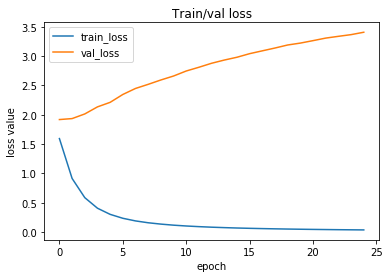

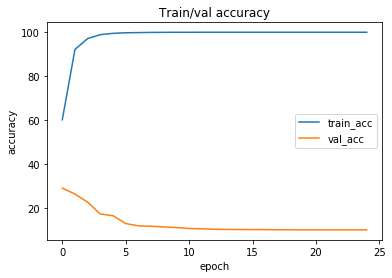

In [0]:
# np.savez('losses_linear_lr1e-3.npz', train_losses=train_losses, val_losses=val_losses, train_accuracies=train_accuracies, val_accuracies=val_accuracies)
# linear_model_data = np.load('losses_linear_lr1e-3.npz')
# train_losses, val_losses, train_accuracies, val_accuracies = linear_model_data['train_losses'], linear_model_data['val_losses'], linear_model_data['train_accuracies'], linear_model_data['val_accuracies']

def plot(n_epochs, train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure()
    plt.plot(np.arange(n_epochs), train_losses)
    plt.plot(np.arange(n_epochs), val_losses)
    plt.legend(['train_loss', 'val_loss'])
    plt.xlabel('epoch')
    plt.ylabel('loss value')
    plt.title('Train/val loss');

    plt.figure()
    plt.plot(np.arange(n_epochs), train_accuracies)
    plt.plot(np.arange(n_epochs), val_accuracies)
    plt.legend(['train_acc', 'val_acc'])
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Train/val accuracy');

plot(n_epochs, train_losses, val_losses, train_acc, val_acc)

#### Report below:
**REPORT** *plots, validation losses and accuracies for different learning rates, learning rate for the selected best performing model*

## Task 3. Evaluate on the test set

In [0]:
# write your code

#### Report below:
**REPORT**:
*Compare validation and test acccuracy. Comment on differences.  
How are test images different from train images?  
Visualize weights of your best linear model. What did the model learn? How does it distinguish images? Why does it fail on test images?*

## Task 4. Fix the observed problem

In [0]:
# write your code

#### Report below
*Traning and validation loss and accuracy for different learning rates  
Learning rate of the best model  
Test loss and accuracy for the best model  
Compare training, val and test loss and accuracy with the previous model  
Visualize weights of the new model, comment on the differences*
